In [13]:
import matplotlib.pyplot as plt

#### Задача
Подумай пока над протоколом для вот такой задачи.
Есть 10 медальонов. Условно говоря, люди с медальонами шарахаются по лесу, время от времени сближаясь на расстояние, достаточное для прохождения сигнала.
Нужно сделать так, чтобы каждый медальон знал, сколько вокруг него других медальонов.

Если два медальона передают одновременно, то случается коллизия, и они друг друга глушат. То есть их никто не слышит.

Так что нужно придумать, как избежать коллизий. Состояние требуется обновлять раз в четыре секунды

#### Протокол передачи данных
**Отправка:** Пусть каждый медальон отправляет пакет со своим ID с частотой X Гц
**Сбор:** Пусть каждый медальон раз в четыре секунды переходит в состояние RX на $2\cdot\frac{1}{X}$

Корректность: Допустим, что каждый медальон выбирает в четырех секундах время для сбора случайно. Тогда вероятность того, что никакие два медальона пересекутся по времени передачи примерно равна $\prod\limits_{i = 2}^{10}{\left(1 - \frac{ 2\cdot\frac{1}{X}}{4}\cdot i \right)}$

Если никакие два медальона не пересекаются по времени приема, то во время приема одного медальона, остальные передают. Поскольку время RX = 2 * период отправки, то каждый медальон отправит хотя бы два раза сообщение принимающему медальону. Предлагается случайно менять время между двумя передачами, чтобы препятствовать синхронизации отдельных медальонов.

Посчитаем энергопотребление, как функцию от частоты
**MCU (4MHZ):**
1. wake up: 1mcS
2. 1mcA sleep current, 4MhZ = 1mA

**CC1101:**
1. wake up: 240mcs from sleep to tx/rx 8.4mA for intermediate consumption
2. 200 nA sleep mode, RX - 15mA, TX - 30mA
3. TX_time = 300mcS

Посчитаем потребление за 4с при скорости отправки 250 kBaud пакета размером 20байт:
#### Время на пробуждение
240mcs
#### Время в TX
0.64ms на отправку
#### Время в RX
$\frac{1}{X}s$


In [66]:
def consumption(x, log=False):
    wake_up_time = 240 * (10 ** -6) * (x + 1) * 4
    tx_time = 0.64 * (10 ** -3) * x * 4 #
    rx_time = 1 / x
    sleep_time = (4 - tx_time - rx_time)
    # mAs
    consumption_mcu = wake_up_time * 1 + tx_time * 1 + rx_time * 1 + sleep_time * (10 ** -3)
    consumption_cc1101 = wake_up_time * 8.4 + tx_time * 30 + rx_time * 15 + sleep_time * 200 * (10 ** -6)
    return consumption_mcu + consumption_cc1101

In [67]:
consumption(100) # mAs for 4 seconds

9.0119048

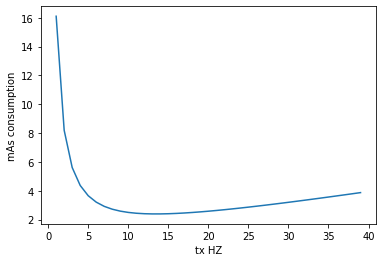

In [71]:
maxHz = 1 / (240 * (10 ** -6) + 0.64 * (10 ** -3))
# print(maxHz)
X = [i for i in range(1, int(40))]
Y = [consumption(x) for x in X]

plt.plot(X, Y)
plt.xlabel('tx HZ')
plt.ylabel('mAs consumption')
plt.show()

In [76]:
C = consumption(15) / 3600 # mAh per second

In [77]:
C

0.0006683679407407408